# Topic Modeling

Read more about the theory and the syntax in these [two](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0) [blogposts](https://medium.com/@pratikbarhate/latent-dirichlet-allocation-for-beginners-a-high-level-intuition-23f8a5cbad71).

In [1]:
import re
import math
import time
import nltk
import gensim
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pyLDAvis.gensim
#lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
#pyLDAvis.display(lda_display)


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

/Applications/anaconda3/lib/python3.7/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/AirMorena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/AirMorena/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/AirMorena/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# pyLDAvis Description
#pyLDAvis is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package 
#extracts information from a fitted LDA topic model to inform an interactive web-based visualization.

In [3]:
def visualize_wordcloud_dict_frequencies(dict_freqs, title, relative_scaling=0.5, max_words=100,
                                background_color='black'):
    plt.figure(figsize=(10, 10))
    wordcloud = WordCloud(width=900, height=500, max_words=max_words, relative_scaling=relative_scaling,
                          normalize_plurals=False, background_color=background_color).generate_from_frequencies(
        dict_freqs)
    plt.title(title)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [4]:
# 2 functions were created one that uses the stemmer method and another the lemmatizer
def tokenizer_stemmer(text, characters, stop_words):
    text_ = text.lower()# make everything lower case
    text_ = re.sub("\d", " ", text_)# it means convert any integer into white space

    for character in characters:
        text_ = text_.replace(character, " ")# replace character by white space

    # initialize tokenizer and tokenize text
    tokenizer = nltk.tokenize.TreebankWordTokenizer()
    list_words = tokenizer.tokenize(text_)# make a list of tokenized words

    # initialize and apply stemmer
    stemmer = nltk.stem.snowball.SnowballStemmer('english')
    text_stemm = [stemmer.stem(word) for word in list_words if word not in stop_words]
    return text_stemm

def tokenizer_lemmatizer(text, characters, stop_words):
    text_ = text.lower()# make everything lower case
    text_ = re.sub("\d", " ", text_)# it means convert any integer into white space

    for character in characters:
        text_ = text_.replace(character, " ")

    # initialize tokenizer and tokenize text
    tokenizer = nltk.tokenize.TreebankWordTokenizer()
    list_words = tokenizer.tokenize(text_)

    # initialize and apply stemmer
    lemmatizer = WordNetLemmatizer()
    text_lemm = [lemmatizer.lemmatize(word) for word in list_words if word not in stop_words]
    return text_lemm


def tokenizer_ner(text, characters, stop_words):# asssign named entity recognition to words
    # Get NER
    return pos_tag(text)

In [5]:
# Use the German stopwords.
stpwrds = stopwords.words("english")

# We added some additional characters to avoid.
characters = [',', '.', '(', ')', '!', ';', '-', ':', '...', '"',
                "''", "``", '~http', '?', '@', '#', '/', "'",
                '&', '--', '[', ']', '=', '||', '+', '_', '..',
                '%', '|', '~', 'http',"\n","—","•","“","„","–",
              "$",">","*"]

In [6]:
len(stpwrds) 

179

In [7]:
# add number to the stopwords list:
mylist= ['10',
 '100',
 '12',
 '15',
 '18',
 '20',
 '2018',
 '30',
 '50',
 '99']
#stpwrds.append(mylist) 

In [8]:
# add the elements of stpwrds to mylist that has the numbers
stpwrds.extend(mylist) 

In [9]:
# check is the numbers were added
#print (stpwrds)

## Load raw reviews and extract sample

In [10]:
# import data from local disk
data = pd.read_csv('/Users/AirMorena/Desktop/final_proj/csv/reviews/data_nlp.csv')

In [11]:
data.shape

(26682, 4)

In [12]:
#data.head()

In [13]:
data['Category'].unique().tolist()

['ART_AND_DESIGN',
 'FAMILY',
 'AUTO_AND_VEHICLES',
 'BEAUTY',
 'BOOKS_AND_REFERENCE',
 'BUSINESS',
 'COMICS',
 'COMMUNICATION',
 'DATING',
 'EDUCATION',
 'ENTERTAINMENT',
 'EVENTS',
 'FINANCE',
 'FOOD_AND_DRINK',
 'HEALTH_AND_FITNESS',
 'HOUSE_AND_HOME',
 'LIBRARIES_AND_DEMO',
 'LIFESTYLE',
 'GAME',
 'SPORTS',
 'MEDICAL',
 'SOCIAL',
 'SHOPPING',
 'PHOTOGRAPHY',
 'TRAVEL_AND_LOCAL',
 'TOOLS',
 'PERSONALIZATION',
 'PRODUCTIVITY',
 'PARENTING',
 'WEATHER',
 'VIDEO_PLAYERS',
 'NEWS_AND_MAGAZINES',
 'MAPS_AND_NAVIGATION']

In [14]:
# condition data with a positive sentiment
data_happy=data[data['Sentiment']=='Positive']
data_happy.shape

(16826, 4)

In [15]:
# select from data angry
data_pos=data_happy[data_happy['Category']=='FINANCE']

In [16]:
data_pos.shape

(802, 4)

In [17]:
# condition data with a negative sentiment
data_angry=data[data['Sentiment']=='Negative']
data_angry.shape

(5979, 4)

In [18]:
# category health and fitness to do the topic modelling
# select from data angry
data_neg=data_angry[data_angry['Category']=='FINANCE']

In [19]:
data_neg.shape

(299, 4)

# Feature extraction

## TF-IDF Vectorization of Translated reviews

Term Frequency-Inverse Document Frequency
As a result, we have a vector representation which gives high value for a given term if that term occurs often in that particular document and very rarely anywhere else. If the term occurs in all the documents, idf computed would be 0. TF-IDF is the product of term-frequency and inverse document frequency.

Tf-idf(w) = tf(w)*idf(w)
The more important a word is in the document, it would get a higher tf-idf score and vice versa.

In [20]:
# Initialise the TF-IDF vectorizer with a given min_document_frequency and max_document_frequency
# we added numbers to stoplist words, so we added this in the hyperparameters
# max_df = 1000 means "ignore terms that appear in more than 1000 documents".
# min_df = 100 means "ignore terms that appear in less than 100 documents

vectorizer = TfidfVectorizer(max_df=20, min_df=10,stop_words=stpwrds)

# Transform the data into normalized frequencies of words
# this steps generates word counts for the words in your docs
X_tfidf = vectorizer.fit_transform(data_neg['Translated_Review'])


# Build the column names dictionary -> ordered dataframe
tfidf_dict = vectorizer.vocabulary_
df_tf_idf_voc = pd.DataFrame({'column_name': list(tfidf_dict.keys()), 'column_index': list(tfidf_dict.values())})
df_tf_idf_voc = df_tf_idf_voc.sort_values(by='column_index')

# Build the matrix dataframe with the right columns
df_X_tfidf = pd.DataFrame(X_tfidf.toarray())
df_X_tfidf.columns = df_tf_idf_voc['column_name'].tolist()

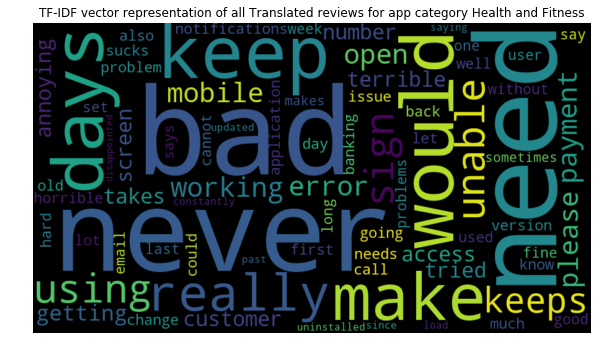

In [21]:
title="TF-IDF vector representation of all Translated reviews for app category Health and Fitness"
d_freq_tfidf = df_X_tfidf.sum().to_dict()
visualize_wordcloud_dict_frequencies(d_freq_tfidf, title, relative_scaling=0.5, max_words=1000,
                                background_color='black')

## Latent Dirichlet Allocation (LDA)

#Latent Dirichlet Allocation (LDA) is a algorithms used to discover the topics that are present in a corpus. 
#A few open source libraries exist, but if you are using Python then the main contender is Gensim. 
#https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

In [28]:
# number of topics per review?

# Tweak the two parameters below

#number of topics to predict
number_topics = 3
# number of words per bacth?
batch_size = 1000

# Topic hyperparameters
# alpha
doc_topic_prior = 1/number_topics
# Beta
topic_word_prior = 1/number_topics

# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=number_topics, 
                                doc_topic_prior=doc_topic_prior,
                                topic_word_prior=topic_word_prior,
                                batch_size=batch_size)
lda.fit(X_tfidf)

# Extract word distributions for the optimized topics from LDA model
topic0 = lda.components_[0]
topic1 = lda.components_[1]
topic2 = lda.components_[2]
#topic3 = lda.components_[3]
words = vectorizer.get_feature_names()

In [29]:
lda.get_params

<bound method BaseEstimator.get_params of LatentDirichletAllocation(batch_size=1000, doc_topic_prior=0.3333333333333333,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=3, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=0.3333333333333333,
             total_samples=1000000.0, verbose=0)>

In [30]:
dict(zip(words, topic0))

{'access': 0.35788527348251536,
 'also': 2.1874693817649598,
 'annoying': 0.34754622336395075,
 'application': 5.739414420002429,
 'back': 2.424577232183466,
 'bad': 10.801320224828492,
 'banking': 0.3492740576293999,
 'call': 0.3469251679101924,
 'cannot': 0.35031195438468965,
 'change': 0.34986604060887366,
 'constantly': 3.4799343394595197,
 'could': 0.349401755056997,
 'customer': 0.8870114128052953,
 'day': 5.780069108506696,
 'days': 0.8746137766869011,
 'disappointed': 0.6360980713335956,
 'email': 0.3481377926990043,
 'error': 0.3566614778289531,
 'fine': 2.533114044477651,
 'first': 2.967662088734393,
 'getting': 0.46543553568639134,
 'going': 0.35018105118836795,
 'good': 0.3523407625335939,
 'hard': 6.301553088137163,
 'horrible': 6.553176639456499,
 'issue': 3.184760938882187,
 'keep': 0.3520771597469975,
 'keeps': 0.34729053268377963,
 'know': 5.151592595428673,
 'last': 1.5430716863469325,
 'let': 5.745765994412373,
 'load': 0.4433085981002573,
 'long': 1.3790091940755378

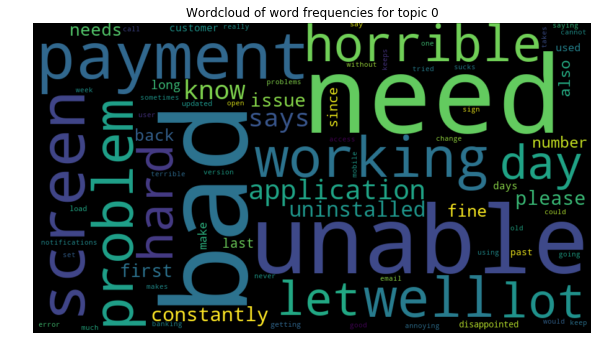

In [31]:
# Create a dictionary between the words and the frequencies for the given topic
d_topic0 = dict(zip(words, topic0))
title="Wordcloud of word frequencies for topic 0"
visualize_wordcloud_dict_frequencies(d_topic0, title, relative_scaling=0.5, max_words=100,
                                background_color='black')

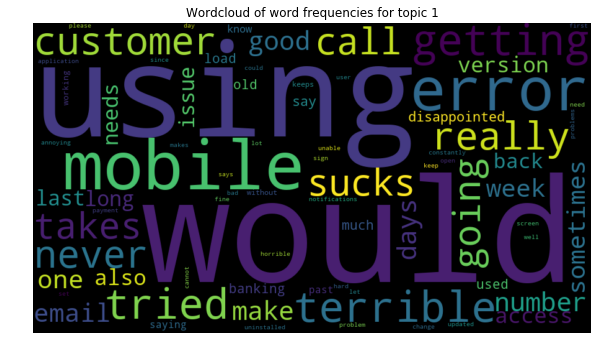

In [32]:
# Create a dictionary between the words and the frequencies for the given topic
d_topic1 = dict(zip(words, topic1))
title="Wordcloud of word frequencies for topic 1"
visualize_wordcloud_dict_frequencies(d_topic1, title, relative_scaling=0.5, max_words=100,
                                background_color='black')

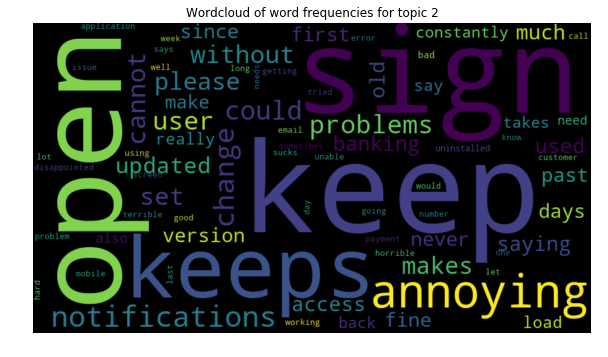

In [33]:
# Create a dictionary between the words and the frequencies for the given topic
d_topic2 = dict(zip(words, topic2))
title="Wordcloud of word frequencies for topic 2"
visualize_wordcloud_dict_frequencies(d_topic2, title, relative_scaling=0.5, max_words=100,
                                background_color='black')

In [34]:
# Create a dictionary between the words and the frequencies for the given topic
d_topic3 = dict(zip(words, topic3))
title="Wordcloud of word frequencies for topic 3"
visualize_wordcloud_dict_frequencies(d_topic3, title, relative_scaling=0.5, max_words=100,
                                background_color='black')

NameError: name 'topic3' is not defined

In [ ]:
#